In [11]:
import numpy as np
import pandas as pd
import json
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.impute import SimpleImputer
import pickle
pd.set_option('display.max_columns', None)
import os

In [2]:
# access creds
with open('../psql_key.json') as file:
    creds = json.load(file)

# Create an SQLAlchemy engine with the PostgreSQL database URI
engine = create_engine(f"postgresql+psycopg2://{creds['user']}:{creds['password']}@{creds['host']}:{creds['port']}/{creds['database']}")

In [3]:
# these diag codes were taken from table mimiciv_hosp.d_icd_diagnoses
hf_codes = '''('39891','40200','40201','40210','40211','40290','40291','40400','40401','40402','40403','40410','40411','40412',
'40413','40490','40491','40492','40493','4280','4281','42820','42821','42822','42823','42830','42831','42832','42833','42840','42841',
'42842','42843','4289','E8726','E8745','I0981','I110','I119','I130','I131','I1310','I1311','I132','I50','I501','I502','I5020','I5021','I5022',
'I5023','I503','I5030','I5031','I5032','I5033','I504','I5040','I5041','I5042','I5043','I508','I5081','I50810','I50811','I50812','I50813','I50814',
'I5082','I5083','I5084','I5089','I509','I9713','I97130','I97131','T8622','T8632','Y625')'''

# get all admissions related to HF codes
query = f'''
select distinct a.subject_id , a.hadm_id , a.admittime , a.dischtime , p.gender , p.anchor_age , p.dod
from (select hadm_id from mimiciv_hosp.diagnoses_icd where icd_code in {hf_codes}) d
inner join (select * from mimiciv_hosp.admissions) a
on a.hadm_id = d.hadm_id
inner join (select * from mimiciv_hosp.patients) p
on p.subject_id = a.subject_id
'''

all_hf_pats_0 = pd.read_sql_query(query , engine)

all_hf_pats_0['dod'] = pd.to_datetime(all_hf_pats_0['dod']).dt.date
all_hf_pats_0['admittime'] = all_hf_pats_0['admittime'].dt.date
all_hf_pats_0['dischtime'] = all_hf_pats_0['dischtime'].dt.date

print(f'patients {all_hf_pats_0.subject_id.nunique()}')

patients 24348


In [16]:
# (OMR) Get online medical record data
reqd_results = ("BMI (kg/m2)" , "Height (Inches)" , "Weight (Lbs)") # Not including BP as I can get it from vitalsigns

q = f'''select distinct subject_id , chartdate , result_name , 
result_value::FLOAT from mimiciv_hosp.omr where result_name in {reqd_results}'''

omr = pd.read_sql_query(q , engine)
# omr = pd.merge(all_hf_pats_0[['subject_id']].drop_duplicates() , omr , on = 'subject_id' , how = 'inner')
omr_ = omr.sort_values(['subject_id' , 'chartdate'] , ascending = True)
omr_pivot = omr_.pivot_table(
    index = ['subject_id' , 'chartdate'] , 
    columns = 'result_name' , 
    values = 'result_value' , 
    aggfunc = 'sum'
).reset_index()

# Checksum
assert np.abs(np.sum(omr_['result_value'].to_numpy()) - np.sum(omr_pivot.iloc[: , -3:].sum(axis = 1))) <= 1e-3 , 'sums not matching'


# # DO NOT BACKFILL ANYTHING NOW
# # Partition-wise backfilling
# omr_pivot['Height (Inches)'] = omr_pivot.groupby('subject_id')['Height (Inches)'].fillna(method='bfill')
# omr_pivot['BMI (kg/m2)'] = omr_pivot.groupby('subject_id')['BMI (kg/m2)'].fillna(method='bfill')
# omr_pivot['Weight (Lbs)'] = omr_pivot.groupby('subject_id')['Weight (Lbs)'].fillna(method='bfill')

# Check level of table
assert len(omr_pivot[['subject_id' , 'chartdate']].drop_duplicates()) == len(omr_pivot) , 'not a patient-date level table!'

# Convert to date
omr_pivot['chartdate'] = pd.to_datetime(omr_pivot['chartdate']).dt.date
omr_pivot.rename(columns = {'chartdate':'charttime'} , inplace = True)

print(omr_pivot.subject_id.nunique())

150427


In [8]:
# RACE
q = '''
select subject_id , race , count(race) as c_race
from mimiciv_hosp.admissions
group by subject_id , race
order by c_race desc
'''

race_0 = pd.read_sql_query(q , engine)
race = race_0.groupby('subject_id').first().reset_index().drop('c_race' , axis = 1)

# QC
assert len(race) == race_0["subject_id"].nunique() , 'is not patient level table'

#QC 
assert race.groupby('subject_id').agg({'race':'nunique'}).sort_values('race' , ascending = False).iloc[0 , ][0] == 1 , 'multiple races'

race_broad = pd.DataFrame( [
    ('AMERICAN INDIAN/ALASKA NATIVE','NATIVE'),
    ( 'ASIAN','ASIAN'),
    ( 'ASIAN - ASIAN INDIAN','ASIAN'),
    ( 'ASIAN - CHINESE','ASIAN'),
    ( 'ASIAN - KOREAN','ASIAN'),
    ( 'ASIAN - SOUTH EAST ASIAN','ASIAN'),
    ( 'BLACK/AFRICAN','BLACK'),
    ( 'BLACK/AFRICAN AMERICAN','BLACK'),
    ( 'BLACK/CAPE VERDEAN','BLACK'),
    ( 'BLACK/CARIBBEAN ISLAND','BLACK'),
    ( 'HISPANIC OR LATINO','HISPANIC'),
    ( 'HISPANIC/LATINO - CENTRAL AMERICAN','HISPANIC'),
    ( 'HISPANIC/LATINO - COLUMBIAN','HISPANIC'),
    ( 'HISPANIC/LATINO - CUBAN','HISPANIC'),
    ( 'HISPANIC/LATINO - DOMINICAN','HISPANIC'),
    ( 'HISPANIC/LATINO - GUATEMALAN','HISPANIC'),
    ( 'HISPANIC/LATINO - HONDURAN','HISPANIC'),
    ( 'HISPANIC/LATINO - MEXICAN','HISPANIC'),
    ( 'HISPANIC/LATINO - PUERTO RICAN','HISPANIC'),
    ( 'HISPANIC/LATINO - SALVADORAN','HISPANIC'),
    ( 'MULTIPLE RACE/ETHNICITY','OTHER'),
    ( 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER','NATIVE'),
    ( 'OTHER','OTHER'),
    ( 'PATIENT DECLINED TO ANSWER','OTHER'),
    ( 'PORTUGUESE','WHITE'),
    ( 'SOUTH AMERICAN','HISPANIC'),
    ( 'UNABLE TO OBTAIN','OTHER'),
    ( 'UNKNOWN','OTHER'),
    ( 'WHITE','WHITE'),
    ( 'WHITE - BRAZILIAN','WHITE'),
    ( 'WHITE - EASTERN EUROPEAN','WHITE'),
    ( 'WHITE - OTHER EUROPEAN','WHITE'),
    ( 'WHITE - RUSSIAN','WHITE')
] , columns = ['race' , 'race_broad']
)
race = pd.merge(race , race_broad , on = 'race' , how = 'inner')
race.drop('race' , axis = 1 , inplace = True)
race.rename(columns = {'race_broad':'race'} , inplace = True)

print(race.subject_id.nunique())

180733


In [9]:
# LAB
q = '''
select distinct subject_id , charttime::DATE , itemid , sum(valuenum) as valuenum from mimiciv_hosp.labevents a 
where a.itemid = 50907 or a.itemid = 50983
or a.itemid = 51222 or a.itemid = 51133
group by subject_id , charttime , itemid 
order by subject_id , charttime
'''

bloodwork = pd.read_sql_query(q , engine) # Takes long time/

bloodwork_pivot = bloodwork.pivot_table(
    index = ['subject_id' , 'charttime'] , 
    columns = 'itemid' , 
    values = 'valuenum' , 
    aggfunc = 'sum'
).reset_index()
 
# Convert to date
bloodwork_pivot['charttime'] = pd.to_datetime(bloodwork_pivot['charttime']).dt.date

# name change
bloodwork_pivot.rename(columns = {50907:'cholesterol' , 50983:'sodium' , 51133:'lymphocyte' , 51222:'hemoglobin'} , inplace = True)

# Checksum
assert np.abs(bloodwork['valuenum'].sum() - np.sum(bloodwork_pivot.iloc[: , -4:].sum(axis = 1))) <= 1e-3 , 'sums not matching'

# QC
assert len(bloodwork_pivot) == len(bloodwork[['subject_id' , 'charttime']].drop_duplicates()) , 'is not patient level table'

print(bloodwork_pivot.subject_id.nunique())

245879


In [10]:
# MEDICATION
hadm_id_list = "('"+"','".join(list(all_hf_pats_0['hadm_id'].unique().astype('str')))+"')"
hadm_id_list

# Note: Leaving out 'atenolol' as it does not have any usage within the cohort 
q = f'''
select a.* from
(
    select subject_id , charttime::DATE , lower(medication) as l_medication , event_txt , hadm_id
    from mimiciv_hosp.emar
    where  hadm_id::VARCHAR in {hadm_id_list}
) a
where a.l_medication in ('amlodipine','diltiazem','felodipine','isradipine','nicardipine',
'nifedipine','nisoldipine','verapamil','azilsartan','candesartan','eprosartan','irbesartan',
'losartan','olmesartan','telmisartan','valsartan','benazepril','captopril','enalapril','fosinopril',
'lisinopril','moexipril','perindopril','quinapril','ramipril','trandolapril','acebutolol','atenolol','Atenolol',
'bisoprolol','metoprolol','nadolol','nebivolol','propranolol')
and a.event_txt = 'Administered'
'''

medication = pd.read_sql_query(q , engine)
medication['medication'] = medication['l_medication']

# pivot
medication_pivot =  medication.pivot_table(
    index = ['subject_id' , 'charttime'] , 
    columns = 'l_medication' , 
    values = 'hadm_id' , 
    aggfunc = 'count'
).fillna(0)

assert medication.shape[0] == np.sum(medication_pivot.sum(axis = 1)) , 'counts not matching'

medication_pivot.reset_index(inplace = True)

# Convert to date
medication_pivot['charttime'] = pd.to_datetime(medication_pivot['charttime']).dt.date

print(medication_pivot.subject_id.nunique())

8047


In [13]:
# Vitalsigns

query = f'''
select subject_id , charttime , avg(temperature) as temperature ,
avg(heartrate) as heartrate , avg(resprate) as resprate , avg(o2sat) as o2sat , 
avg(sbp) as sbp , avg(dbp) as dbp 
from 
(
    select subject_id , charttime::DATE , temperature , heartrate , resprate , o2sat , sbp , dbp
    from mimiciv_ed.vitalsign
) a
group by subject_id , charttime
'''
vitalsign = pd.read_sql_query(query , engine)

# Convert to date
vitalsign['charttime'] = pd.to_datetime(vitalsign['charttime']).dt.date

assert len(vitalsign) == len(vitalsign[['subject_id' , 'charttime']].drop_duplicates()) , 'is not patient level table'

print(vitalsign.subject_id.nunique())

198131


### **Joining**

In [30]:
charttime_pats = pd.merge(
    bloodwork_pivot[['subject_id']] , vitalsign[['subject_id']] , on = 'subject_id' , how = 'inner'
    ).merge(
        medication_pivot[['subject_id']] , on = 'subject_id' , how = 'inner'
    ).merge(
        omr_pivot[['subject_id']] , on = 'subject_id' , how = 'inner'
    )['subject_id']

MemoryError: Unable to allocate 87.5 GiB for an array with shape (11744197584,) and data type int64

In [28]:
df_1 = pd.merge(
    vitalsign , bloodwork_pivot , 
    on = ['subject_id' , 'charttime'] , 
    how = 'outer'
)

df_2 = pd.merge(
    df_1 , medication_pivot , 
    on = ['subject_id' , 'charttime'] , 
    how = 'outer'
)

df_3 = pd.merge(
    df_2 , omr_pivot , 
    on = ['subject_id' , 'charttime'] , 
    how = 'outer'
)

df_4 = pd.merge(
    df_3 , race , 
    on = 'subject_id' , 
    how = 'outer'
)

# sort by patient-time
df_4.sort_values(['subject_id' , 'charttime'] , inplace = True)

print(f'patients {df_4.subject_id.nunique()}')

patients 281043


In [11]:
# Retain patients who do not have any presence in the charttime
retain_pats = df_3.groupby('subject_id').agg({'charttime':'nunique'})
retain_pats = retain_pats[retain_pats['charttime'] != 0]
retain_pats = retain_pats.reset_index().drop('charttime', axis=1).drop_duplicates()

#### **Get Survival Metrics**

In [12]:
# Retain all patients
# Add num of ICU admits / num of admissions as covariates
# Time of survival -> from last ICU admission to deathtime / OR first ICU admission?
# Uncensored patients (those that experienced the event, i.e. died)
# Find latest ICU admission
tos_hf = all_hf_pats_0.groupby('subject_id').agg({'admittime':'min' , 'dod':'max' , 'dischtime':'max'})
event_pats = tos_hf[tos_hf['dod'].notnull()].copy()
event_pats['time_to_event'] = event_pats['dod'] - event_pats['admittime']
event_pats['time_to_event'] = event_pats['time_to_event'] / np.timedelta64(1, 'D') # convert to hours
event_pats['death'] = 1

# who are the censored patients?
non_event_pats = tos_hf[tos_hf['dod'].isnull()].copy()# For censored patients, their last follow-up was essentially their discharge time
non_event_pats['time_to_event'] = non_event_pats['dischtime'] - non_event_pats['admittime']
non_event_pats['time_to_event'] = non_event_pats['time_to_event'] / np.timedelta64(1, 'D') # convert to hours
# non_event_pats['time_to_event'] = non_event_pats['time_to_event'] + 365 # is this necessary?
non_event_pats['death'] = 0
# non_event_pats.head(3)

pats = pd.concat([non_event_pats[['time_to_event' , 'death']] , event_pats[['time_to_event' , 'death']]] , axis = 0)
pats.reset_index(inplace = True)
pats.sort_values('subject_id' , inplace = True)

pats['time_to_event'] = pats['time_to_event'].apply(lambda x: x+1 if x==0 else x)
# QC
print(pats.count())

# QC
assert len(pats) == all_hf_pats_0["subject_id"].nunique() , 'is not patient level table'

subject_id       24348
time_to_event    24348
death            24348
dtype: int64


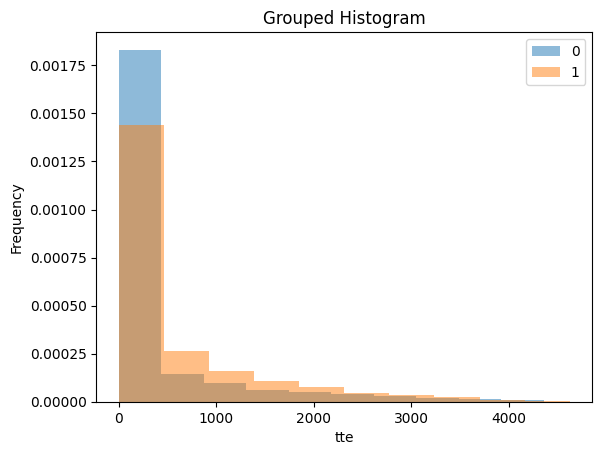

In [13]:
grouped = pats.groupby('death')

# Plot grouped histogram
fig, ax = plt.subplots()
for category, group in grouped:
    ax.hist(group['time_to_event'], label=category, alpha=0.5, bins=10 , density = True)

ax.legend()
plt.xlabel('tte')
plt.ylabel('Frequency')
plt.title('Grouped Histogram')
plt.show()

In [14]:
consolidated_pat_tbl = pd.merge(df_3 , pats , on = 'subject_id' , how = 'inner')
print(f'number of patients before retaining = {consolidated_pat_tbl.subject_id.nunique()}')
consolidated_pat_tbl = pd.merge(consolidated_pat_tbl , retain_pats , on = 'subject_id' , how = 'inner')

# # Forwardfilling columns
# forwardfill_cols = [
#     'cholesterol', 'sodium', 'lymphocyte', 'hemoglobin', 'temperature', 
#     'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp'
#     ]

# for col in forwardfill_cols:
#     consolidated_pat_tbl[col] = consolidated_pat_tbl.groupby('subject_id')[col].fillna(method = 'ffill')

# # na -> zero columns (Must do this AFTER backfilling!)
# consolidated_pat_tbl.fillna(0 , inplace = True)

print(f'number of patients after retaining = {consolidated_pat_tbl.subject_id.nunique()}')

assert len(consolidated_pat_tbl) == len(consolidated_pat_tbl[['subject_id','charttime']].drop_duplicates()) , 'not patient-time level!'

number of patients before retaining = 24348
number of patients after retaining = 24329


In [15]:
# Time difference calculation at patient level
consolidated_pat_tbl['lag_time'] = consolidated_pat_tbl.groupby('subject_id')['charttime'].shift(1)
consolidated_pat_tbl['timediff'] = consolidated_pat_tbl['charttime'] - consolidated_pat_tbl['lag_time']
consolidated_pat_tbl['timediff'] = consolidated_pat_tbl['timediff'].fillna(pd.Timedelta(0))
consolidated_pat_tbl['timediff'] = consolidated_pat_tbl['timediff']/np.timedelta64(1 , 'D')

**Retain patients with at least n time steps**

In [16]:
def retain_n_time_steps(df, subject_col, ts_col, n_time_steps = 10):
    arr = df.groupby(subject_col).agg({ts_col:'count'})[ts_col]
    
    # Calculate the quantile value using np.quantile - patients below this quantile are rejected
    print(f'% rejected pats {100*np.sum(arr < n_time_steps)/len(arr)}')
    
    _retain_pats = df.groupby(subject_col).agg({ts_col:'count'}).reset_index()
    _retain_pats = _retain_pats[_retain_pats[ts_col] >= n_time_steps]

    df_retained = pd.merge(df , _retain_pats[[subject_col]] , on = subject_col , how = 'inner')

    # check operations correctness
    assert np.sum(arr < n_time_steps)/len(arr) == (df[subject_col].nunique() - df_retained[subject_col].nunique())/df[subject_col].nunique() , 'does not match'
    
    return df_retained

In [17]:
consolidated_pat_tbl_retained = retain_n_time_steps(
    consolidated_pat_tbl.drop(['charttime','lag_time'] , axis = 1),
    'subject_id' , 'timediff'
    )

% rejected pats 26.010111389699535


In [18]:
folder_path = "data/"

# Check if the folder exists
if not os.path.exists(folder_path):
    # Create the folder
    os.makedirs(folder_path)

# Pickle the DataFrame (tv -> time variant)
with open('data/consolidated_pat_tbl_tv.pickle', 'wb') as file:
    pickle.dump(consolidated_pat_tbl_retained, file)

------------

In [19]:
# _ = consolidated_pat_tbl_retained.groupby('subject_id').\
#          agg({'timediff':'count'}).reset_index().\
#          groupby('timediff').agg({'subject_id':'nunique'}).sort_values('subject_id' , ascending=False).\
#          reset_index()

# plt.scatter(_.timediff , _.subject_id, s = 1)
# # plt.xscale('log')